In [25]:
import time, torch, torch_struct
import torch
import torch_struct
import matplotlib.pyplot as plt
import tqdm as tqdm
%timeit

In [41]:
def show(m, ex):
    #plt.figure(figsize = (10,10))
    plt.style.use('seaborn-dark-palette')
    #plt.style.context('dark_background')
    plt.tick_params(labelsize=10)
    plt.yticks(torch.arange(len(letters[ex])), letters[ex])
    plt.xticks(torch.arange(T), [str(frames[ex][x.item()]) for x in torch.arange(T)])
    plt.imshow(m[ex].cpu().detach())

## Alignment Algorithm
Input strings are `ref_string_list` and `new_string_list` for batches of pars of ref-new.

We use CTC loss to calculate global and local alignment between the two sequences. 
We use the fact that we have labels of entities for the ref_string to use for token tagging


In [42]:
# ref_string = "State ofNew Jersey, Schedule, NJK-1, 2019, Partnerâ€™sShare, of Income, (Form, NJ-1065), , For Calendar Year 2019, or Fiscal Year Beginning"
# new_string = "STATE OF NEW JERSEY, NJK-1, (Form NJ-1065), PARTNER'S, SHARE, OF, INCOME, 2018, For Calendar Year 2018, or Fiscal Year Beginning"
ref_string = "abcde"
new_string = "abbdd"
t_start = time.time()
%timeit


In [43]:
ref_string_list_ = [(list(word)) for word in ref_string]
ref_string_list = ["".join(s) for s in ref_string_list_]
new_string_list_ = [(list(word)) for word in new_string]
new_string_list = ["".join(s) for s in new_string_list_]
ref_string_list, new_string_list

(['a', 'b', 'c', 'd', 'e'], ['a', 'b', 'b', 'd', 'd'])

## Character Vocab and Padding


In [44]:
# Character Vocab, P is a padding token
#vocab = ["1","2","3","4","5","6","7","8","9","a", "b", "c", "d", "e", "_", "P","PAD","W","s","h","g","o","n","t","v","r","L","i","D","C"]
vocab = list(set(new_string_list+ref_string_list))
len(ref_string), len(new_string)
v_dict = { a:i for i, a in enumerate(vocab)}
L = len(vocab)

# # Char sequence
letters = [new_string_list,new_string_list]
#new seq len
t = len(letters[0])

# Padding
frames = [ref_string_list,ref_string_list]
# Constants
T, B = len(frames[0]), len(frames)
D1, MATCH, D2 = 0, 1, 2

batch_lengths = [(t, T), (t, T)]
#batch_lengths = [(t, T)]
T,B

b, i = len(frames[0]),len(frames[1])



## Gold alignment

In [45]:

gold = torch.zeros(B, t).long()
for b in range(B):
    for i, l in enumerate(letters[0]):
        gold[b, i] = v_dict[l]
gold = gold[:, None, :].expand(B, T, t)

# Inputs (boost true frames a bit)
logits = torch.zeros(B, T, L)
for b in range(B):
    for i in range(T):
        
        logits[b, i, v_dict[frames[b][i]]] += 1
        

# Construct the alignment problem from CTC

# Log-Potentials
log_potentials = torch.zeros(B, T, t, 3).fill_(-1e5)

# Match gold to logits. 
match = torch.gather(logits, 2, gold)

# CTC Rules:
for b, (lb, la)  in zip(range(B), batch_lengths):
    # la and lb are the sizes of the two (without padding)

    # Never allowed to fully skip regular characters (little t)
    log_potentials[b, :la, :lb:2,  D2] = -1e5

    # Free to skip _ characters (little t)
    log_potentials[b, :la, 1:lb:2, D2] = 0

    # First match with character is the logit. 
    log_potentials[b, :la, :lb, MATCH] = match[b, :la, :lb]

    # Additional match with character is the logit.
    log_potentials[b, :la, :lb, D1] = match[b, :la, :lb]

    # Match padding in an L shape
    log_potentials[b, la:, lb-1, D1] = 0
    log_potentials[b, -1, lb:, D2] = 0

log_potentials = log_potentials.transpose(1, 2)

#log_potentials = log_potentials.transpose(1, 2).cuda()
matches = match.transpose(1,2).exp()
matches

tensor([[[2.7183, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 2.7183, 1.0000, 1.0000, 1.0000],
         [1.0000, 2.7183, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 2.7183, 1.0000],
         [1.0000, 1.0000, 1.0000, 2.7183, 1.0000]],

        [[2.7183, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 2.7183, 1.0000, 1.0000, 1.0000],
         [1.0000, 2.7183, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 2.7183, 1.0000],
         [1.0000, 1.0000, 1.0000, 2.7183, 1.0000]]])

# Plots of semirings

## input scores


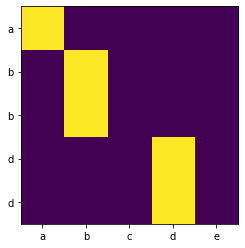

In [46]:
show(matches, 1)
#matches[0], matches[1]

## Calculate distribution

> Pick local (Smith-Waterman, or Global,Needleman-Wunsch)

In [47]:

dist = torch_struct.AlignmentCRF(log_potentials,local=False)


## Marginals
>(see uncertainty from randomness)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 5, 5, 3])

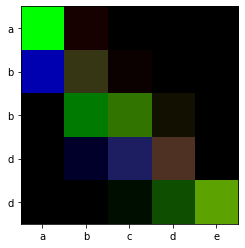

In [48]:
show(dist.marginals, 1)
#marginals
dist.marginals.shape

## Count

In [49]:
count_ = dist.count

## Partition

In [50]:
partition_ = dist.partition

## Argmax

(torch.Size([2, 5, 5, 3]),
 tensor([[0, 0, 0, 1],
         [0, 1, 0, 2],
         [0, 2, 1, 1],
         [0, 2, 2, 0],
         [0, 3, 2, 2],
         [0, 4, 3, 1],
         [0, 4, 4, 0],
         [1, 0, 0, 1],
         [1, 1, 0, 2],
         [1, 2, 1, 1],
         [1, 2, 2, 0],
         [1, 3, 2, 2],
         [1, 4, 3, 1],
         [1, 4, 4, 0]]))

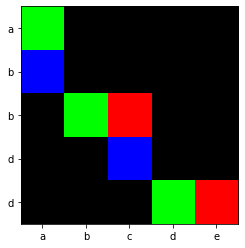

In [51]:
argmax_ = dist.argmax
show(argmax_,1)
argmax_.shape, argmax_.nonzero()

In [52]:
max_ = dist.max
#show(max_,1)
max_

tensor([3., 3.], grad_fn=<SqueezeBackward1>)

In [53]:
argmax_[0]

tensor([[[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]])

In [54]:
argmax_[1]

tensor([[[0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]])

In [55]:
argmax_[0] == argmax_[1]

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]]])